In this notebook we investigate the differences between the native state (state A, eRMSD from native less than 0.7) compared to state B. In our MD+eNOE ensemble, state B consists in non-native loop conformations. 

In this analysis we train a random forest classifier in the space of different observables (angles, distances, etc) that can discriminate state A from state B. Training and test examples are bootstraped from the optimal MD+set A distribution.

The classifier returns a score for each input feature. The higher the score, the more important the corresponding feature for classification.


In [1]:
# import libraries
import barnaba as bb
from barnaba import definitions
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
np.random.seed(144)

In [2]:
# read weights from file
theta=20
data_tmp = np.array([[float(x) for x in line.split()] for line in open("data/weights_set_A1_t_%d.dat" % (theta),"r")])
weights = data_tmp[:,1]

# draw 50k samples 
nsamples = 50000
ff = np.random.choice(len(weights),size=50000,p=weights/np.sum(weights),replace=True)

# split between state  A and B
ermsd_full = pickle.load(open("data/observables/ermsd_full.p",'rb'), encoding='bytes')
ermsd_new = ermsd_full[ff]
ii = np.where(ermsd_new<0.7)[0]
jj = np.where(ermsd_new>=0.7)[0]
bb= len(ii)+len(jj)
print(len(ii),len(jj),len(ii)/bb,len(jj)/bb,bb)

42448 7552 0.84896 0.15104 50000


# define the random forest classifier, using sklearn implementation

In [3]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn import metrics


def rfc(x,y,labels,outfile,train_fraction=0.8,max_depth=3):

    x = np.array(x)
    y = np.array(y)
    # do some sanity checks
    assert(y.shape[0]==x.shape[0])
    assert(len(labels)==x.shape[1])

    # shuffle and split in training/test set
    randomize = np.arange(len(y))
    np.random.shuffle(randomize)
    stop_train = int(train_fraction*(y.shape[0]))

    x_train = x[randomize][:stop_train,:]
    y_train = y[randomize][:stop_train]

    x_test = x[randomize][stop_train:,:]
    y_test = y[randomize][stop_train:]
    print("# number of training examples: %d" % x_train.shape[0])
    print("# number of test     examples: %d" % x_test.shape[0])
    print("# number of input features:    %d" % x_test.shape[1])


    # define classifier
    clf = RandomForestClassifier(n_estimators=100,n_jobs=20,max_depth=max_depth)
    
    clf.fit(x_train,y_train)
    y_pred_train=clf.predict(x_train)
    y_pred_test=clf.predict(x_test)
    str1 = "# Training accuracy %5.3f (%s)\n" % (metrics.accuracy_score(y_train,y_pred_train),x_train.shape)
    str1 += "# Test     accuracy %5.3f (%s)" % (metrics.accuracy_score(y_test,y_pred_test),x_test.shape)
    str2 = "# Training F1 score %5.3f (%s)\n" % (metrics.f1_score(y_train,y_pred_train),x_train.shape)
    str2 += "# Test     F1 score %5.3f (%s)" % (metrics.f1_score(y_test,y_pred_test),x_test.shape)
    print(str1)
    print(str2)
    #fh = open(outfile,"w")
    #fh.write(str1 + "\n")
    #fh.write(str2 + "\n")
    sorted_imp = np.argsort(clf.feature_importances_)[::-1]

    my_idx = []
    yy = clf.feature_importances_/np.max(clf.feature_importances_)
    for i,el in enumerate(sorted_imp):
        str3 = "%4d %4d %20s %6.4f " % (i,el,labels[el],yy[el])
        if(i<21): print(str3)
        if(yy[el]>0.2): my_idx.append(el)
    #    fh.write(str3+"\n")
    #fh.close()
    #stats = [metrics.accuracy_score(y_train,y_pred_train),metrics.f1_score(y_train,y_pred_train),\
    #        metrics.accuracy_score(y_test,y_pred_test),metrics.f1_score(y_test,y_pred_test)]
    stats = []

    return stats, my_idx

# train a Random Forest with torsion angles as input features

In [4]:
# read pickle from file
angles,res = pickle.load(open("data/observables/angles.p",'rb'), encoding='bytes')
mask = np.ones(14*7, dtype=bool)
# mask nans at the termini
mask[0]= False
mask[1] = False
mask[-2] = False
mask[-3] = False
# reshape
ll = angles.shape[0]
angles = angles.reshape(ll,14*7)[:,mask]

# bootstrap using the indeces crated above
angles_new = angles[ff,:]
# split in state A and B
angles_A = angles_new[ii,:]
angles_B = angles_new[jj,:]


In [5]:
# define labels to make it human-readable
labels = [["%s_%s" % (i,el) for el in definitions.bb_angles] for i in res]
l = 0
labels1 = []
for j in range(len(labels)):
    for k in range(len(labels[j])):
        if(mask[l]): labels1.append(labels[j][k])
        l+=1

X = np.vstack([angles_A,angles_B])
Y = np.hstack([np.ones(len(angles_A)), np.zeros(len(angles_B))])
print(X.shape,Y.shape,len(labels1))
stats = rfc(X,Y,labels=labels1,outfile="crap",max_depth=3)

(50000, 94) (50000,) 94
# number of training examples: 40000
# number of test     examples: 10000
# number of input features:    94
# Training accuracy 0.989 ((40000, 94))
# Test     accuracy 0.988 ((10000, 94))
# Training F1 score 0.993 ((40000, 94))
# Test     F1 score 0.993 ((10000, 94))
   0   52           C_8_0_zeta 1.0000 
   1   59           G_9_0_zeta 0.6472 
   2   51            C_8_0_eps 0.3946 
   3   54          G_9_0_alpha 0.2798 
   4   45           U_7_0_zeta 0.2606 
   5   62          G_10_0_beta 0.2343 
   6   60            G_9_0_chi 0.2189 
   7   44            U_7_0_eps 0.2076 
   8   38           U_6_0_zeta 0.2013 
   9   50          C_8_0_delta 0.1976 
  10   43          U_7_0_delta 0.1919 
  11   40          U_7_0_alpha 0.0883 
  12   56          G_9_0_gamma 0.0852 
  13   57          G_9_0_delta 0.0842 
  14   49          C_8_0_gamma 0.0807 
  15   53            C_8_0_chi 0.0629 
  16   42          U_7_0_gamma 0.0381 
  17   63         G_10_0_gamma 0.0378 
  18  

We can see that C8 zeta and C9 zeta are the most important features for classification. We plot below the corresponding histograms

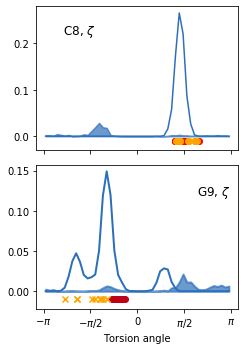

In [6]:
# read data for 2koc and 6by5 as a reference
angles_2koc,res = pickle.load(open("data/observables/angles_2koc.p",'rb'), encoding='bytes')
angles_6by5,res = pickle.load(open("data/observables/angles_6by5.p",'rb'), encoding='bytes')

# initialize plot
fig,ax = plt.subplots(2,1,figsize=(3.5,5),sharex=True)
plt.subplots_adjust(left=0.15, bottom=0.12, right=0.95, top=0.96, wspace=0.25, hspace=0.1)

bins = np.linspace(-np.pi, np.pi,50)
z = angles_A.shape[0]+angles_B.shape[0]

hh,ee = np.histogram(angles_A[:,52],bins=bins)
xx = (ee[1:]+ee[:-1])*0.5
hh1,ee1 = np.histogram(angles_B[:,52],bins=bins)
xx1 = (ee1[1:]+ee1[:-1])*0.5

ax[0].plot(xx,hh/z,c='#2c6fbb',ls="-",lw=1.5)
ax[0].fill_between(xx1,hh1/z,color='#2c6fbb',ls="-",lw=1.5,alpha=0.7)
ax[0].scatter(angles_2koc[:,7,5],[-0.01]*len(angles_2koc),c='red')
ax[0].scatter(angles_6by5[:,7,5],[-0.01]*len(angles_6by5),c='orange')
ax[0].text(-2.5,0.22,"C8, $\zeta$",fontsize=12)
hh,ee = np.histogram(angles_A[:,59],bins=bins)
xx = (ee[1:]+ee[:-1])*0.5
hh1,ee1 = np.histogram(angles_B[:,59],bins=bins)
xx1 = (ee1[1:]+ee1[:-1])*0.5

ax[1].plot(xx,hh/z,c='#2c6fbb',ls="-",lw=2)
ax[1].fill_between(xx1,hh1/z,color='#2c6fbb',ls="-",lw=2,alpha=0.7)
ax[1].set_xticks([-np.pi,-np.pi/2,0,np.pi/2.,np.pi])
oo = ax[1].set_xticklabels(["$-\pi$","$-\pi/2$","0","$\pi/2$","$\pi$"])
ax[1].scatter(angles_2koc[:,8,5],[-0.01]*len(angles_2koc),c='#be0119',marker="o")
ax[1].scatter(angles_6by5[:,8,5],[-0.01]*len(angles_6by5),c='orange',marker="x")
ax[1].text(2,0.12,"G9, $\zeta$",fontsize=12)
ax[1].set_xlabel("Torsion angle")
ax[0].set_yticks([0,0.1,0.2])
#plt.savefig("figures/angles_hist.pdf")
#plt.savefig("figures/angles_hist.png",dpi=600)
#plt.close()

# train a Random Forest with distances between center of 6-memeberd rings as input features

In [7]:
# read distance vectors from pickle
rvecs,res = pickle.load(open("data/observables/rvecs.p",'rb'), encoding='bytes')

ll = rvecs.shape[0]

ii_t = np.triu_indices(14,1)
rdist1 = np.sqrt((rvecs**2).sum(axis=3))
ids = np.arange(ll)
# take entries from upper diagonal
rdist = np.array([rdist1[el][ii_t] for el in ids])

# bootstrap
rdist_new = rdist[ff]
rvecs_A = rdist_new[ii,:]
rvecs_B = rdist_new[jj,:]


We do not use the distances directly, but a switching function of the distance

In [8]:
def switch(xx,a=0.5):
    r6 = (xx/a)**6
    r12 = r6*r6
    return (1.-r6)/(1.-r12)

labels_rvecs = []
for i,el in enumerate(res):
    for j in range(i+1,len(res)):
        labels_rvecs.append("%s:%s" % (el,res[j]))
X = np.vstack([rvecs_A,rvecs_B])
X = np.vstack([switch(rvecs_A),switch(rvecs_B)])

Y = np.hstack([np.ones(len(rvecs_A)), np.zeros(len(rvecs_B))])
print(X.shape,Y.shape,len(labels_rvecs))
stats = rfc(X,Y,labels=labels_rvecs,outfile="crap",max_depth=3)

(50000, 91) (50000,) 91
# number of training examples: 40000
# number of test     examples: 10000
# number of input features:    91
# Training accuracy 0.998 ((40000, 91))
# Test     accuracy 0.999 ((10000, 91))
# Training F1 score 0.999 ((40000, 91))
# Test     F1 score 0.999 ((10000, 91))
   0   56          U_6_0:C_8_0 1.0000 
   1   57          U_6_0:G_9_0 0.9945 
   2   76         G_9_0:G_10_0 0.7677 
   3   70          C_8_0:G_9_0 0.7216 
   4   49          C_5_0:G_9_0 0.6648 
   5   39          A_4_0:C_8_0 0.4604 
   6   40          A_4_0:G_9_0 0.4560 
   7   48          C_5_0:C_8_0 0.4559 
   8   77         G_9_0:U_11_0 0.3482 
   9   64          U_7_0:G_9_0 0.3050 
  10   29          C_3_0:C_8_0 0.2744 
  11   63          U_7_0:C_8_0 0.2492 
  12   78         G_9_0:G_12_0 0.2460 
  13   30          C_3_0:G_9_0 0.2092 
  14   79         G_9_0:C_13_0 0.2072 
  15   73         C_8_0:G_12_0 0.2003 
  16   71         C_8_0:G_10_0 0.1410 
  17   80         G_9_0:C_14_0 0.1337 
  18  

We find u6-G9 and U6-C8 as the most important features. We then make a 2-d histogram that show the distribution of these two quantities

In [9]:
from scipy import stats


datax = np.sqrt(np.sum(rvecs[:,5,7,:]**2,axis=1))
datay = np.sqrt(np.sum(rvecs[:,5,8,:]**2,axis=1))
xa=np.arange(1.05*np.min(datax),1.05*np.max(datax),0.025)
ya=np.arange(1.05*np.min(datay),1.05*np.max(datay),0.025)
#print(datax.shape,(weights_0.reshape(-1)).shape)
kernel = stats.gaussian_kde(np.array([datax,datay]),weights=weights,bw_method=0.15)

X, Y = np.meshgrid(xa,ya)
grid_coords = np.vstack([X.ravel(), Y.ravel()])
H = np.reshape(kernel(grid_coords).T, X.shape)



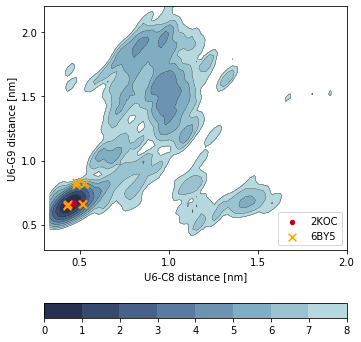

In [10]:
# vectors connecting center of nucleobases
fname = "data/observables/rvecs_2koc.p"
[rvecs_2koc,res_2koc] = pickle.load(open(fname,'rb'), encoding='bytes')

fname = "data/observables/rvecs_6by5.p"
[rvecs_6by5,res_6by5] = pickle.load(open(fname,'rb'), encoding='bytes')

d_69_2koc = np.sqrt(np.sum(rvecs_2koc[:,5,8,:]**2,axis=1))
d_69_6by5 = np.sqrt(np.sum(rvecs_6by5[:,5,8,:]**2,axis=1))

d_68_2koc = np.sqrt(np.sum(rvecs_2koc[:,5,7,:]**2,axis=1))
d_68_6by5 = np.sqrt(np.sum(rvecs_6by5[:,5,7,:]**2,axis=1))

Z= -(np.log(H))
Z -= np.min(Z)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import seaborn as sns 

levels = [0,1,2,3,4,5,6,7,8]
sns.set_palette(sns.color_palette("cubehelix", len(levels)-1))
cmap = sns.cubehelix_palette(len(levels)-1, as_cmap=True,reverse=True,rot=-0.2)

fig,ax = plt.subplots(1,1,figsize=(5., 5.5))


plt.subplots_adjust(left=0.14, bottom=0.1, right=0.98, top=0.98, wspace=0.07, hspace=0.1)

plt.xlim(0.3,2.)
plt.ylim(0.3,2.2)
CS = ax.contourf(X, Y, Z,levels=levels,cmap=cmap)
CS1 = ax.contour(X, Y, Z,levels=levels,colors='k',linewidths=0.3)

CB = fig.colorbar(CS,orientation="horizontal")

plt.scatter(d_68_2koc,d_69_2koc,s=20,c='#be0119',label='2KOC',marker='o',zorder=10)
plt.scatter(d_68_6by5,d_69_6by5,s=60,c='orange',label='6BY5',marker="x",zorder=10)
plt.legend(ncol=1,loc="lower right")
#plt.xlabel("eRMSD from native (residues 4-11)")
plt.ylabel("U6-G9 distance [nm]")
plt.xlabel("U6-C8 distance [nm]")
plt.xticks([0.5,1,1.5,2])
plt.yticks([0.5,1,1.5,2])
#plt.savefig("figures/2d_projection.png",dpi=600)
#plt.savefig("figures/2d_projection.pdf")
plt.show()
#plt.close()
#plt.figure(figsize=(8,8))
#plt.scatter(rvecs_A[:,56], rvecs_A[:,57],s=1.5,zorder=10)
#lt.scatter(rvecs_B[:,56], rvecs_B[:,57],s=1.5,zorder=10)

 # Train a Random Forest with experimental data as input features
 Here we perform an analysis identical to the one performed before. The difference is that we use as input features the experimental data. This allows us to determine the experimental observations that are most sensitive to the presence of state B. We inspect them in detail and compare them with the reference ensemble 2KOC. 

In [11]:
import pandas as pd
from scipy import stats

# define a function that returns the labels fo the most important fatures ( more than 0.2)
def analyse(dirname,name):
    data_calc = pd.read_csv("%s/%s.calc.dat" % (dirname,name),header=None,sep="\s+",index_col=0,comment="#")

    data_pdb = pd.read_csv("%s/2koc.%s.calc.dat" % (dirname,name),header=None,sep="\s+",index_col=0,comment="#")
    data_exp = pd.read_csv("%s/%s.exp.dat" % (dirname,name),names=["label","exp","sigma"],sep="\s+",comment="#")
    labels = data_exp["label"].values

    if("NOE" in name):
        data_new = np.power(data_calc.values[ff,:],-1/6.)
        data_pdb = np.power(data_pdb.values,-1/6.)
    else:
        data_new = data_calc.values[ff,:]
        data_pdb = data_pdb.values
        
    # bootstrap
    data_B = data_new[jj,:]
    data_A = data_new[ii,:]
    X = np.vstack([data_A,data_B])
    Y = np.hstack([np.ones(len(data_A)), np.zeros(len(data_B))])
    data = []
    
    # train the classifier
    stats,sorted_idx = rfc(X,Y,labels=labels,outfile="%s/%s.rf" % (dirname,name),max_depth=3)
    labels_sorted = []
    for j in sorted_idx:
        full = data_new[:,j].mean()
        sA = data_A[:,j].mean()
        sB = data_B[:,j].mean()
        v2koc = data_pdb[:,j].mean()
        if("NOE" in name):
            full = np.power(full,-6)
            sA = np.power(sA,-6)
            sB = np.power(sB,-6)
            v2koc = np.power(v2koc,-6)
        stri = "%20s %4.2f %4.2f %4.2f %4.2f %4.2f" % (labels[j],data_exp.values[j,1],full,sA,sB,v2koc)
        data.append([data_exp.values[j,1],data_exp.values[j,2],full,sA,sB,v2koc])
        labels_sorted.append(labels[j])
    return np.array(data), labels_sorted



# number of training examples: 40000
# number of test     examples: 10000
# number of input features:    177
# Training accuracy 0.999 ((40000, 177))
# Test     accuracy 0.999 ((10000, 177))
# Training F1 score 0.999 ((40000, 177))
# Test     F1 score 0.999 ((10000, 177))
   0   16         U6_H6;C8_H41 1.0000 
   1   10         C8_H1';G9_H1 0.6817 
   2   38         U6_H2';C8_H5 0.5397 
   3   83         U6_H1';G9_H1 0.5080 
   4  157        U6_H3';C8_H41 0.4937 
   5   48       G9_H2';G10_H4' 0.4898 
   6    2          U6_H6;G9_H1 0.4701 
   7   12          C8_H6;G9_H1 0.4516 
   8   45        C8_H4';G9_H3' 0.3734 
   9    7         G9_H1;G10_H8 0.3441 
  10    5         G9_H1;G10_H1 0.3370 
  11  117         U6_H2';C8_H6 0.3118 
  12  154       C14_H41;C14_H5 0.1664 
  13    6        G9_H1;G10_H1' 0.1553 
  14   19         C8_H5";G9_H1 0.1531 
  15   88         U7_H2';G9_H1 0.1508 
  16   76        C8_H5";G9_H5" 0.1282 
  17   11          C8_H5;G9_H1 0.1191 
  18   77       G10_H5";G

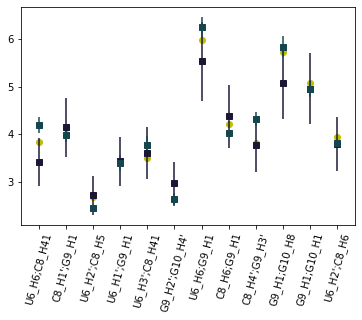

# number of training examples: 40000
# number of test     examples: 10000
# number of input features:    63
# Training accuracy 0.998 ((40000, 63))
# Test     accuracy 0.997 ((10000, 63))
# Training F1 score 0.999 ((40000, 63))
# Test     F1 score 0.998 ((10000, 63))
   0   30        U6_H2';C8_H41 1.0000 
   1   12         U6_H2';G9_H1 0.9309 
   2   11        U6_HO2';G9_H1 0.8807 
   3   59         C8_H5';G9_H8 0.6453 
   4   58         C8_H5";G9_H8 0.5987 
   5   39         C8_H4';G9_H8 0.5284 
   6    0        C8_H4';G10_H8 0.1800 
   7   21       C13_H41;C13_H5 0.1753 
   8   32       C13_H42;C13_H5 0.1103 
   9   24        G2_H1;C13_H41 0.1081 
  10   14        U6_HO2';U7_H6 0.1051 
  11   13       U6_H2';U6_HO2' 0.0830 
  12   25        G2_H1;C13_H42 0.0578 
  13   56        C8_H4';C8_H5" 0.0483 
  14   42        G10_H8;U11_H6 0.0280 
  15   36         U6_H2';U7_H6 0.0247 
  16   43          C5_H6;U6_H6 0.0181 
  17   40         G9_H2';G9_H8 0.0157 
  18   37         U6_H2';U6_H6

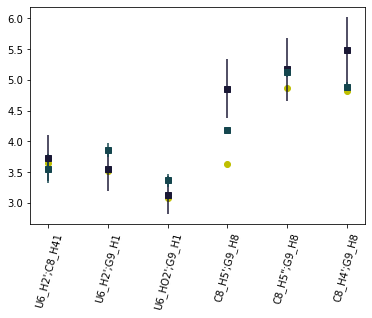

# number of training examples: 40000
# number of test     examples: 10000
# number of input features:    251
# Training accuracy 0.998 ((40000, 251))
# Test     accuracy 0.998 ((10000, 251))
# Training F1 score 0.999 ((40000, 251))
# Test     F1 score 0.999 ((10000, 251))
   0   90         U6_H6;C8_H41 1.0000 
   1  124         U6_H5;C8_H41 0.8587 
   2  150         C8_H1';G9_H1 0.8293 
   3  123        U6_H3';C8_H41 0.7303 
   4   77         U6_H2';C8_H5 0.6286 
   5  146         U6_H1';G9_H1 0.5381 
   6  126        U6_H2';C8_H42 0.5219 
   7   80         U6_H3';C8_H5 0.5166 
   8  127        U6_H3';C8_H42 0.4916 
   9  145         G9_H1;G10_H8 0.4699 
  10  134        C8_H5;U7_H5'' 0.4347 
  11   91         U6_H6;C8_H42 0.3996 
  12  122        U6_H2';C8_H41 0.3715 
  13  147         U6_H2';G9_H1 0.3412 
  14  137         U6_H2';C8_H6 0.3410 
  15  133         C8_H5;U7_H5' 0.3204 
  16  128       C8_H42;U7_H5'' 0.2755 
  17  148        U6_HO2';G9_H1 0.2316 
  18  153          C8_H6;

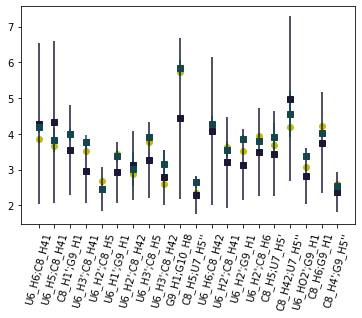

# number of training examples: 40000
# number of test     examples: 10000
# number of input features:    96
# Training accuracy 0.969 ((40000, 96))
# Test     accuracy 0.970 ((10000, 96))
# Training F1 score 0.982 ((40000, 96))
# Test     F1 score 0.982 ((10000, 96))
   0   40               8-C4Pe 1.0000 
   1   27              10-C4Pb 0.8968 
   2   88              U7-H3H4 0.8134 
   3   67              U7-H1H2 0.7250 
   4   68              C8-H1H2 0.5445 
   5   89              C8-H3H4 0.5278 
   6   18              10-1H5P 0.5012 
   7   69              G9-H1H2 0.3929 
   8   49             G9-2H5H4 0.3107 
   9   90              G9-H3H4 0.2873 
  10    7              10-2H5P 0.2540 
  11   59             G9-1H5H4 0.2349 
  12   33                8-H3P 0.2060 
  13   41               9-C4Pe 0.1962 
  14   32                7-H3P 0.1265 
  15   80              G9-H2H3 0.1243 
  16   48             C8-2H5H4 0.1210 
  17   39               6-C4Pe 0.1102 
  18   17               9-1H5P

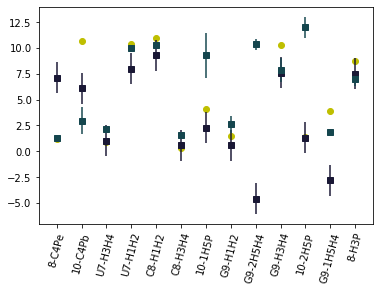

# number of training examples: 40000
# number of test     examples: 10000
# number of input features:    32
# Training accuracy 0.978 ((40000, 32))
# Test     accuracy 0.979 ((10000, 32))
# Training F1 score 0.987 ((40000, 32))
# Test     F1 score 0.988 ((10000, 32))
   0   12      10.G.C8-10.G.H8 1.0000 
   1    4        8.C.C6-8.C.H6 0.9549 
   2   29      10.G.N1-10.G.H1 0.5789 
   3    2        6.U.C6-6.U.H6 0.3958 
   4   22      9.G.C1'-9.G.H1' 0.2344 
   5   21      8.C.C1'-8.C.H1' 0.2323 
   6   11        9.G.C8-9.G.H8 0.2295 
   7   19      6.U.C1'-6.U.H1' 0.1974 
   8    9        2.G.C8-2.G.H8 0.1366 
   9    1        5.C.C6-5.C.H6 0.1284 
  10   25    13.C.C1'-13.C.H1' 0.0906 
  11   20      7.U.C1'-7.U.H1' 0.0769 
  12    8        1.G.C8-1.G.H8 0.0758 
  13    5      11.U.C6-11.U.H6 0.0519 
  14   18      5.C.C1'-5.C.H1' 0.0378 
  15    6      13.C.C6-13.C.H6 0.0349 
  16   17      4.A.C1'-4.A.H1' 0.0304 
  17   26    14.C.C1'-14.C.H1' 0.0275 
  18    7      14.C.C6-14.C.H6

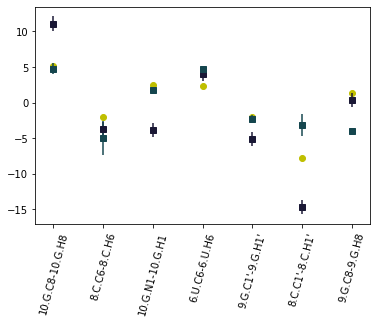

# number of training examples: 40000
# number of test     examples: 10000
# number of input features:    39
# Training accuracy 0.992 ((40000, 39))
# Test     accuracy 0.993 ((10000, 39))
# Training F1 score 0.995 ((40000, 39))
# Test     F1 score 0.996 ((10000, 39))
   0   19      8.C.C4'-8.C.H4' 1.0000 
   1   21        8.C.C6-8.C.H6 0.7354 
   2   23      8.C.C3'-8.C.H3' 0.6955 
   3   25      9.G.C3'-9.G.H3' 0.4021 
   4   14        6.U.C6-6.U.H6 0.2431 
   5   24      9.G.C1'-9.G.H1' 0.2012 
   6   29      11.U.C5-11.U.H5 0.1874 
   7   20      8.C.C1'-8.C.H1' 0.1221 
   8   28      11.U.C6-11.U.H6 0.1048 
   9   13      6.U.C1'-6.U.H1' 0.0906 
  10   10        5.C.C6-5.C.H6 0.0831 
  11    3        2.G.C8-2.G.H8 0.0721 
  12   16      7.U.C4'-7.U.H4' 0.0562 
  13   12      5.C.C2'-5.C.H2' 0.0479 
  14   32    13.C.C1'-13.C.H1' 0.0458 
  15   38      14.C.C6-14.C.H6 0.0354 
  16   26    10.G.C1'-10.G.H1' 0.0330 
  17    4        3.C.C5-3.C.H5 0.0260 
  18    1        1.G.C8-1.G.H8

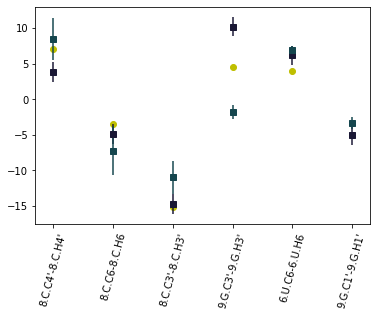

# number of training examples: 40000
# number of test     examples: 10000
# number of input features:    14
# Training accuracy 0.976 ((40000, 14))
# Test     accuracy 0.976 ((10000, 14))
# Training F1 score 0.986 ((40000, 14))
# Test     F1 score 0.986 ((10000, 14))
   0    8      10.G.C8-10.G.H8 1.0000 
   1   13      7.U.C2'-7.U.H2' 0.4384 
   2    7      9.G.C2'-9.G.H2' 0.3700 
   3   12    10.G.C3'-10.G.H3' 0.2428 
   4    9    11.U.C3'-11.U.H3' 0.2162 
   5    4      6.U.C2'-6.U.H2' 0.1192 
   6   11      6.U.C4'-6.U.H4' 0.1010 
   7    3      4.A.C1'-4.A.H1' 0.0779 
   8    1      1.G.C2'-1.G.H2' 0.0319 
   9    2      2.G.C4'-2.G.H4' 0.0263 
  10    0      1.G.C1'-1.G.H1' 0.0206 
  11    5        7.U.C6-7.U.H6 0.0138 
  12    6        7.U.C5-7.U.H5 0.0078 
  13   10      14.C.C5-14.C.H5 0.0007 


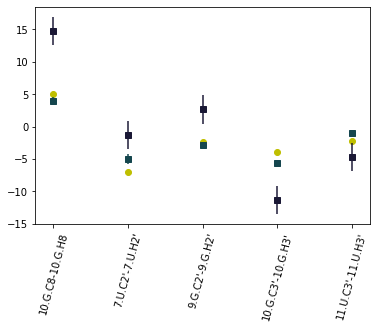

# number of training examples: 40000
# number of test     examples: 10000
# number of input features:    91
# Training accuracy 0.998 ((40000, 91))
# Test     accuracy 0.998 ((10000, 91))
# Training F1 score 0.999 ((40000, 91))
# Test     F1 score 0.999 ((10000, 91))
   0   50               9GuaH1 1.0000 
   1   43              8CytH3' 0.4811 
   2   42             8Cyt1H2' 0.4320 
   3   63            10Gua1H5' 0.3604 
   4   41              8CytH1' 0.3551 
   5   62             10GuaH3' 0.3326 
   6   52             9Gua1H2' 0.2738 
   7   36              7UraH4' 0.2058 
   8   65              10GuaH8 0.2049 
   9   48             8Cyt1H5' 0.1722 
  10   45              8CytH41 0.1457 
  11   46              8CytH42 0.1146 
  12   53              9GuaH3' 0.1112 
  13   29               6UraH3 0.1103 
  14   44              8CytH4' 0.1010 
  15   34              7UraH1' 0.0668 
  16   28             6Ura1H2' 0.0576 
  17   35             7Ura1H2' 0.0517 
  18   64            10Gua2H5'

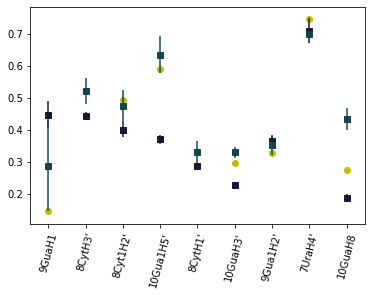

In [12]:
# here we plot the calculated/experimental values, together with  the value from 2KOC
files = [["data/set_A1/","eNOE_unidir"],["data/set_A1/","eNOE"],\
         ["data/set_B/","NOE"],["data/set_B/","J3"],["data/set_B/","RDC"],["data/set_C/","RDC1"],["data/set_C/","RDC2"],["data/set_D/","sPRE"]]


rwn = "set_A1"
theta=20
suspects = []
for el in files:
    data, labels = analyse(el[0],el[1])

    calc = np.ones((len(labels),4))*1e10
    for k in range(4):
        nmf = "data/comparison_n/%s/rw_%s_%s_theta_%d_rep_%d.stats.dat"  % (rwn,el[0].split("/")[-2],el[1],theta,k)
        df = pd.read_csv(nmf,header=None,sep="\s+",index_col=0,comment="#")
        for il,lab in enumerate(labels):
            calc[il,k] = df.loc[lab].values[-1]
    data_pdbf = "data/comparison/%s/2koc_%s.stats.dat"  % (el[0].split("/")[-2],el[1])
    #data_pdbf = "data/comparison/%s/6by5_%s.stats.dat"  % (el[0].split("/")[-2],el[1])
    
    df = pd.read_csv(data_pdbf,header=None,sep="\s+",index_col=0,comment="#")
    data_pdb = np.ones(len(labels))*1e10
    for il,lab in enumerate(labels):
        data_pdb[il] = df.loc[lab].values[-1]
    xx = np.arange(data.shape[0])
    plt.errorbar(xx,data[:,0],yerr=data[:,1],fmt="s",label="exp") 
    plt.errorbar(xx,calc.mean(axis=1),yerr=calc.std(axis=1,ddof=1),fmt="s",label="calc")

    plt.scatter(xx,data_pdb,label="2KOC",c="y")
    for pp in range(len(labels)):
        #diff1 = np.abs(data[pp,0]-calc.mean(axis=1)[pp])/data[pp,1]
        #diff2 = np.abs(data[pp,0]-data_pdb[pp])/data[pp,1]
        #if(diff1>0.0 or diff2>0.0):
        suspects.append(["%s-%s" % (el[1],labels[pp]), data[pp,0], data[pp,1],calc.mean(axis=1)[pp],data_pdb[pp],calc.std(axis=1,ddof=1)[pp]])
    plt.xticks(xx,labels,rotation=75)
    #plt.legend()
    plt.show()
    plt.close()

To understand whether our MD+eNOE ensemble better reflects the loop dynamics, we make a scatter plot showing the Z-score of 2KOC vs the Z-score for MD+enoe. Points below the diagonal indicate that 2KOC has a lower error than MD+eNOE

['eNOE_unidir', 'eNOE', 'NOE', 'J3', 'RDC', 'RDC1', 'RDC2', 'sPRE']
1 eNOE-C8_H5';G9_H8 1.372942386831276 2.520576131687244
2 J3-G9-2H5H4 9.982833333333334 9.993333333333334
3 RDC-8.C.C1'-8.C.H1' 11.481275 6.899
4 RDC1-8.C.C3'-8.C.H3' 2.725178571428571 0.3
5 RDC2-10.G.C8-10.G.H8 4.905681818181818 4.459545454545454
6 sPRE-9GuaH1 3.8465588680880156 7.259748629715119
7 sPRE-10Gua1H5' 17.983137062977143 14.884951654417456
8 sPRE-10GuaH8 18.577008540081813 6.697978375741858
42 78
4.422396972817336
3.3317326617035543


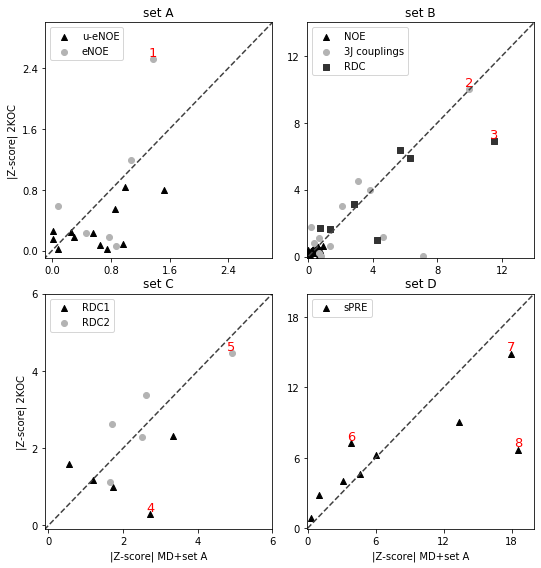

2.416445977681154 1.9441781258061301


In [15]:
#print(suspects)
A1 = ["eNOE_unidir","eNOE"]
A2 = ["RDC","NOE","J3"]
A3 = ["RDC1","RDC2"]
A4 = ["sPRE"]
suspects2 = []
labels2 = []
classes = {"eNOE_unidir":"^","eNOE":"o","NOE":"^","J3":"o","RDC":"s","RDC1":"^","RDC2":"o","sPRE":"^"}
classes_c = {"eNOE_unidir":"k","eNOE":"0.7","NOE":"k","J3":"0.7","RDC":"0.2","RDC1":"k","RDC2":"0.7","sPRE":"k"}
legends = {"eNOE_unidir":"u-eNOE","eNOE":"eNOE","NOE":"NOE","J3":"3J couplings","RDC":"RDC","RDC1":"RDC1",\
           "RDC2":"RDC2","sPRE":"sPRE"}

legends_lab = [0]*len(legends)
legends_name = list(legends.keys())
print(legends_name)

leg = []
cols = []
for j in range(len(suspects)):
    suspects2.append(suspects[j][1:])
    labels2.append(suspects[j][0])
    leg.append(classes[suspects[j][0].split("-")[0]])
    cols.append(classes_c[suspects[j][0].split("-")[0]])
    #print(labels2[-1])
suspects2 = np.array(suspects2)
#yy = np.arange(len(suspects2))

x = np.abs((suspects2[:,0]-suspects2[:,2]))/suspects2[:,1]
y = np.abs((suspects2[:,0]-suspects2[:,3]))/suspects2[:,1]
cha = [str(e) for e in range(100)]
nnu = 1
selection = ["eNOE-C8_H5';G9_H8","J3-G9-2H5H4","RDC-8.C.C1'-8.C.H1'","RDC1-8.C.C3'-8.C.H3'","RDC2-10.G.C8-10.G.H8",\
            "sPRE-10Gua1H5'","sPRE-9GuaH1","sPRE-10GuaH8"]

selection_data = []
fig, ax = plt.subplots(2,2,figsize=(8,8))
plt.subplots_adjust(left=0.1, bottom=0.07, right=0.95, top=0.95, wspace=0.15, hspace=0.15)
pdb_best =0 
for u in range(len(x)):
    #print(labels2[u])
        
    if(labels2[u].split("-")[0] in A1): i1,i2,ln = 0,0,len(A1)
    if(labels2[u].split("-")[0] in A2): i1,i2,ln = 0,1,len(A2)
    if(labels2[u].split("-")[0] in A3): i1,i2,ln = 1,0,len(A3)
    if(labels2[u].split("-")[0] in A4): i1,i2,ln = 1,1,len(A4)
    if(x[u]>y[u]): pdb_best +=1
    if(legends_lab[legends_name.index(labels2[u].split("-")[0])]==0):
        ax[i1,i2].scatter(x[u],y[u],marker=leg[u],color=cols[u],label=legends[labels2[u].split("-")[0]])
        legends_lab[legends_name.index(labels2[u].split("-")[0])] += 1
    else:
        ax[i1,i2].scatter(x[u],y[u],marker=leg[u],color=cols[u])
    if(labels2[u] in selection):
        print(nnu,labels2[u],x[u],y[u])
        ax[i1,i2].text(x[u],y[u],cha[nnu],ha="center",va="bottom",fontsize=13,color="r")
        selection_data.append([suspects2[u,0],suspects2[u,1],suspects2[u,2],suspects2[u,4],suspects2[u,3]])
        nnu += 1
print(pdb_best,len(x))
print(np.sqrt((x**2).mean()))
print(np.sqrt((y**2).mean()))

lims = [3.0,14,6,20]
k = 0 
for i1 in range(2):
    for i2 in range(2):
        ax[i1,i2].plot([-1,22],[-1,22],ls="--",c='0.25')
        ax[i1,i2].set_xlim(-0.1,lims[k])
        ax[i1,i2].set_ylim(-0.1,lims[k])
        ax[i1,i2].xaxis.set_major_locator(plt.MaxNLocator(4))
        ax[i1,i2].yaxis.set_major_locator(plt.MaxNLocator(4))

        #ax[i1,i2].set_xticks(4)
        #ax[i1,i2].set_yticks(4)
        k += 1
ax[0,0].set_ylabel("|Z-score| 2KOC")
ax[1,0].set_ylabel("|Z-score| 2KOC")
ax[1,0].set_xlabel("|Z-score| MD+set A")
ax[1,1].set_xlabel("|Z-score| MD+set A")
ax[0,0].set_title("set A")
ax[0,1].set_title("set B")
ax[1,0].set_title("set C")
ax[1,1].set_title("set D")
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
plt.savefig("figures/direct_comparison0.pdf")
plt.savefig("figures/direct_comparison0.png",dpi=600)
#plt.close()
plt.show()
print(x.mean(),y.mean())    

8


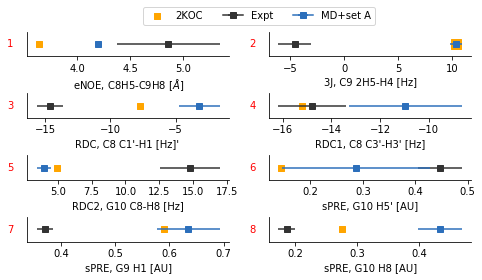

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
selection_name = ["eNOE, C8H5-C9H8 [$\AA$]","3J, C9 2H5-H4 [Hz]","RDC, C8 C1'-H1 [Hz]' ","RDC1, C8 C3'-H3' [Hz]",\
                  "RDC2, G10 C8-H8 [Hz]","sPRE, G10 H5' [AU]","sPRE, G9 H1 [AU]","sPRE, G10 H8 [AU]"]
print(len(selection_data))
fig, ax = plt.subplots(4,2,figsize=(7,4))
l = 0
plt.subplots_adjust(left=0.07, bottom=0.12, right=0.95, top=0.85, wspace=0.2, hspace=1.5)
for i in range(4):
    for k in range(2):
        ax[i,k].errorbar(selection_data[l][0],0.5,xerr=selection_data[l][1],fmt="s-",c="0.2",label="Expt")
        #print(selection_data[i])
        ax[i,k].errorbar(selection_data[l][2],0.5,xerr=selection_data[l][3],fmt="s-",label="MD+set A",c="#2c6fbb")
        if(l==1):
            ax[i,k].scatter(selection_data[l][4],0.5,c="orange",marker="s",label="2KOC",s=120)
        else:
            ax[i,k].scatter(selection_data[l][4],0.5,c="orange",marker="s",label="2KOC")
        if(i==0 and k == 0): 
            ax[i,k].legend(ncol=3,loc=1,bbox_to_anchor=(1.75,2.2))
        ax[i,k].set_yticks([])
    #ax[i].set_yticklabels(str(i+1),color="r",fontsize=12)
        ax[i,k].spines["top"].set_visible(False)
        ax[i,k].spines["right"].set_visible(False)
        #ax[i,k].spines["left"].set_visible(False)
        xm = ax[i,k].get_xlim()[0]
        xr = np.abs(ax[i,k].get_xlim()[1]-xm)
        ax[i,k].text(xm-0.1*xr,0.5,"%s" % (str(l+1)),va="center",ha="left",color="r",fontsize=10)
        ax[i,k].set_xlabel(selection_name[l])
    #ax[i].spines["left"].set_visible(False)

        l += 1
        
plt.savefig("figures/direct_comparison.pdf")
plt.savefig("figures/direct_comparison.png",dpi=600)
plt.show()
#plt.close()